In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import requests
import os
import scipy.signal
import scipy.stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import KFold
from dateutil.relativedelta import relativedelta
import time
from dateutil.tz import gettz
from datetime import timedelta
import calendar
import datetime
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)


In [13]:
# Create and preprocess data for appliance: vacuum


vacuum = pd.read_csv('disagData/vacuum_harmonics.csv')
# vacuum_h = vacuum_h.iloc[1000:6000]
vacuum.drop('ts',axis=1, inplace=True)
vacuum['label'] = np.nan
vacuum['label'].iloc[:519]=0
vacuum['label'].iloc[519:856]=1
vacuum['label'].iloc[856:6361]=2
vacuum['label'].iloc[6361:6415]=1
vacuum['label'].iloc[6415:]=0
# vacuum_p.drop('ts',axis=1, inplace=True)
# vacuum_p = vacuum_p.iloc[1000:6000]
# vacuum = pd.concat([vacuum_p[['pwrA','rpwrA']],vacuum_h],axis = 1)
# vacuum.reset_index(inplace=True, drop=True)
cols = ['ihd03A','ihd05A','ihd07A','ithdA']
# resample and extract features
vacuum_pr = pd.DataFrame([])
for col in cols:
    vacuum_pr[col+'_mean'] = vacuum[col].groupby(np.arange(len(vacuum))//50).mean()
    vacuum_pr[col+'_std'] = vacuum[col].groupby(np.arange(len(vacuum))//50).std()
    vacuum_pr[col+'_min'] = vacuum[col].groupby(np.arange(len(vacuum))//50).min()
    vacuum_pr[col+'_max'] = vacuum[col].groupby(np.arange(len(vacuum))//50).max()
vacuum_pr['label'] = vacuum['label'].groupby(np.arange(len(vacuum))//50).agg(lambda x:x.value_counts().index[0])
    
# vacuum_pr['label'] = 1

# vacuum_pr.head(100)

In [22]:
# Create and preprocess data for appliance: laptop

laptop = pd.read_csv('disagData/laptop_harmonics.csv')
laptop.drop('ts',axis=1, inplace=True)
laptop['label'] = np.nan
laptop['label'].iloc[:689]=0
laptop['label'].iloc[689:696]=1
laptop['label'].iloc[696:]=3


cols = ['ihd03A','ihd05A','ihd07A','ithdA']
# resample and extract features
laptop_pr = pd.DataFrame([])
for col in cols:
    laptop_pr[col+'_mean'] = laptop[col].groupby(np.arange(len(laptop))//50).mean()
    laptop_pr[col+'_std'] = laptop[col].groupby(np.arange(len(laptop))//50).std()
    laptop_pr[col+'_min'] = laptop[col].groupby(np.arange(len(laptop))//50).min()
    laptop_pr[col+'_max'] = laptop[col].groupby(np.arange(len(laptop))//50).max()
    
laptop_pr['label'] = laptop['label'].groupby(np.arange(len(laptop))//50).agg(lambda x:x.value_counts().index[0])
# laptop_pr.info()

In [31]:
# Create and preprocess data for appliance: hairdryer

hairdryer = pd.read_csv('disagData/hairdryer_harmonics.csv')
hairdryer = hairdryer.iloc[:400]
hairdryer.drop('ts',axis=1, inplace=True)
hairdryer = hairdryer[['ihd03A','ihd05A','ihd07A','ithdA']]


# resample and extract features
hairdryer_pr = pd.DataFrame([])
for col in hairdryer.columns:
    hairdryer_pr[col+'_mean'] = hairdryer[col].groupby(np.arange(len(hairdryer))//50).mean()
    hairdryer_pr[col+'_std'] = hairdryer[col].groupby(np.arange(len(hairdryer))//50).std()
    hairdryer_pr[col+'_min'] = hairdryer[col].groupby(np.arange(len(hairdryer))//50).min()
    hairdryer_pr[col+'_max'] = hairdryer[col].groupby(np.arange(len(hairdryer))//50).max()
    
hairdryer_pr['label'] = 4



In [153]:
# Create and preprocess data for appliance: treadmill

# treadmill_p = pd.read_csv('disagData/treadmill_power.csv')
# treadmill_h = pd.read_csv('disagData/treadmill_harmonics.csv')
# treadmill_h = treadmill_h.iloc[1000:3500]
# treadmill_h.drop('ts',axis=1, inplace=True)
# treadmill_p.drop('ts',axis=1, inplace=True)
# treadmill_p = treadmill_p.iloc[1000:3500]
# treadmill = pd.concat([treadmill_p[['pwrA','rpwrA']],treadmill_h],axis = 1)
# treadmill.reset_index(inplace=True, drop=True)

# # resample and extract features
# treadmill_pr = pd.DataFrame([])
# for col in treadmill.columns:
#     treadmill_pr[col+'_mean'] = treadmill[col].groupby(np.arange(len(treadmill))//50).mean()
#     treadmill_pr[col+'_std'] = treadmill[col].groupby(np.arange(len(treadmill))//50).std()
#     treadmill_pr[col+'_min'] = treadmill[col].groupby(np.arange(len(treadmill))//50).min()
#     treadmill_pr[col+'_max'] = treadmill[col].groupby(np.arange(len(treadmill))//50).max()
    
# treadmill_pr['label'] = 3

In [33]:
df = pd.concat([vacuum_pr,hairdryer_pr,laptop_pr],axis=0,sort=False)
df.reset_index(inplace=True, drop=True)
df.describe()

,ihd03A_mean,ihd03A_std,ihd03A_min,ihd03A_max,ihd05A_mean,ihd05A_std,ihd05A_min,ihd05A_max,ihd07A_mean,ihd07A_std,ihd07A_min,ihd07A_max,ithdA_mean,ithdA_std,ithdA_min,ithdA_max,label
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,64.798497,1.359026,62.616253,67.493023,54.532331,2.416033,49.775176,58.078944,46.349519,3.810761,38.599482,51.297640,139.192791,7.110196,127.008282,152.967122,2.501035
std,34.771510,3.726167,33.908492,36.726309,36.841554,3.399724,34.198613,39.110738,31.297384,4.877435,27.395233,35.431825,82.222154,13.845874,75.463382,92.668456,0.909550
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.283600,0.013899,23.260000,23.300000,3.788100,0.012841,3.760000,3.800000,3.062500,0.013813,3.040000,3.080000,24.031400,0.024580,24.000000,24.070000,2.000000
50%,88.623800,1.263771,85.550000,91.250000,79.915800,1.509536,69.310000,84.550000,66.790800,1.848172,48.620000,74.230000,194.650000,5.510368,176.270000,207.090000,3.000000
75%,89.943100,1.657098,87.200000,92.390000,82.172100,4.259278,78.140000,85.870000,70.668600,7.412661,64.485000,75.785000,200.104400,9.705544,186.305000,218.105000,3.000000
max,92.744400,65.172848,90.830000,231.570000,85.462000,52.385105,83.810000,210.520000,75.393600,69.605600,74.180000,285.710000,263.915600,188.480116,199.780000,399.990000,4.000000


In [34]:
y = df['label'].values
X = df.drop('label',axis=1)
X = preprocessing.MinMaxScaler().fit_transform(X)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

skf = StratifiedKFold(n_splits=10, shuffle=True)
# clf = DecisionTreeClassifier(random_state=0)
clf = KNeighborsClassifier(n_neighbors=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    clf = clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print('y pred:',y_pred)
    print('y test:',y_test)
    print('acc of fold is:',acc)

y pred: [ 0.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  0.  4.  0.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
y test: [ 0.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  4.  0.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
acc of fold is: 0.979591836735
y pred: [ 0.  0.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  4.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
y test: [ 0.  0.  0.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  4.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
acc of fold is: 0.979591836735
y pred: [ 0.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  4.  0.  0.  3.
  3.  3.  3.  3.  3.  3. 

C:\Users\Emily\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


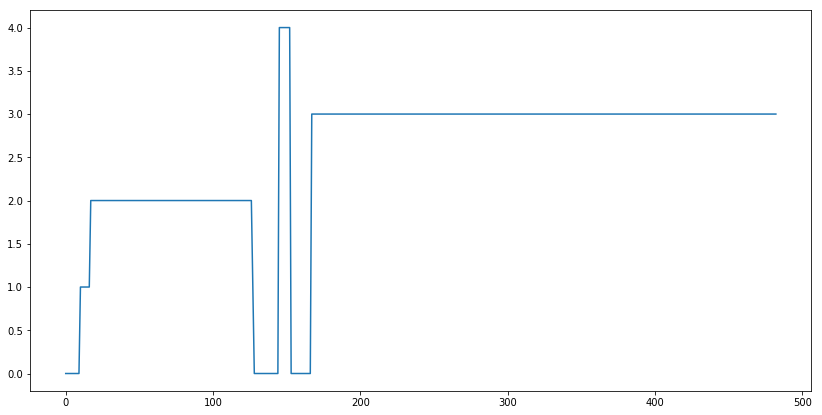

In [38]:
fig = plt.figure(figsize=[14,7])
plt.plot(df.index,df['label'])